# This is the template for coursework B - Add a suitable title

<div class="alert alert-block alert-danger">
<b>Candidate number: Your candidate number here (this is a five digit number). </b>

- This Coursework contributes <b>80%</b> to your overall unit mark.

- Will be marked anonymously.

- Keep to word limits (+- a few words).

- You can use the WordCounter notebook to check your word count.

- Code & figure captions do not count towards word limits.
</div>

### Abstract: 

Here, give an overview of your work, make sure to describe the science background, methods, results as well as comparisons to literature data. Keep this short.
<div class="alert alert-block alert-danger">
    
<b>word limit 250 words.</b>

#### Imports: give all your imports in a box here. Any custom code you have stored in a .py file needs to be submitted with your coursework. You can freely use all code provided to you as part of this course. If you use code not encountered in the course, give a link to the online repo.

In [2]:
#Data handling
import numpy as np
import pandas as pd 
from astropy.io import fits #used to open fits files in which data are stored
import glob
import os 

#Signal processing imports

from scipy.signal import savgol_filter, lombscargle
from scipy.optimize import curve_fit
import scipy 

#Modelling imports 
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import pymc3_ext as pmx

#Visualization imports 
import arviz as az
import corner
import matplotlib.pyplot as plt
import seaborn as sns

#Progress bars
import tqdm
from typing import Optional

#Utils file 
from utils import fold_lightcurve# ,chisquared_reduced


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#Filter warnings for ignore level, this isn't always a good idea but theano warnings are very verbose.
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-danger">
<b>Make sure to include the relevant python files in your upload</b>

### 1. Introduction:

Give an introduction to your coursework. This should be a short description of exoplanets as well as a description of background relevant to your Discussion.

Your introduction should be understandable to a student having taken Intro to astro and Planets & Exoplanets. 

<div class="alert alert-block alert-danger">
<b>Word limit: 600 words</b>

A central problem in astronomy is the search for other planets bearing life.
In recent years TESS George R. Ricker(2018) surveys have discovered thousands of confirmed exoplanets orbiting a range of stellar hosts. Of these confirmed transits indicating an exoplanet orbiting a star, only a small subset of these bodies are candidates for hosting life. There has consequently been a large body of research (CITE ME) on generating likely candidates for habitable exoplanets from large-scale sky surveys such as TESS or KEPLER- Michael Mewhinney (2013).



Keystone indicators for habitability come from a range of sources; from time series data of the stellar flux of a star, we can detect exoplanets by periodic drops in flux. These troughs, coined 'transits' by astronomers, are caused by the partial occlusion of the view of a star from an observation telescope.
After confirming the presence of an exoplanet, astronomical spectrometry and radial velocity can be used to find the exoplanet's mass, atmospheric composition, and temperature as the key indicators of suitability for life.
Before justifying this extra analysis and instrument time however, we can look at the transit curves to derive the mass ratio of the host star and exoplanet and the orbit's semi-major axis.


Additionally, measuring stellar and transit parameters allows researchers to further describe the exoplanet's path through space, and by extension confidence in their astrophysical model. Parameters of interest are the stellar limb darkening (the extent to which the central part of the star 'disk' seems brighter than its edges), the impact parameter (the verticle elevation distance between the center of the star and the exoplanet as defined below)

$$ b = \frac{a cos(i)}{R_{*}}$$


Often the extent to which a given exoplanet's orbit deviates from being circular, its eccentricity, is also considered a prominent factor in habitability, Yuwei Wang(2017).

Striving to be confident in their results for exoplanet measurements, instead of expressing these quantities as scalars, many astronomers choose to treat transit light curve data as a stochastically variable time series. Researchers can obtain probabilistic estimates of the parameters characterizing these transits using gaussian process or Markov-chain Monte Carlo (MCMC) simulations. These models yield bayesian estimates for their parameters, allowing for rigorous considerations of error, confidence, and parameter correlation.


In this work, we will perform an in-depth analysis of a reading of stellar flux from the Kepler telescope to confirm the existence of two orbiting exoplanets. Using various periodograms, we will derive estimates of the number of exoplanets in the stellar system and their respective orbital periods. After this, we will find their mass ratio and average transit length, taking an average over a series of transits.


Additionally, for the body with the larger semi-major axis more rigorous analysis will be applied- we will fit a gaussian process model to its folded light curve. From this model, we will generate estimates of the posterior distribution for stellar properties, orbital parameters, and transit jitter. This will allow us to describe the environment of the exoplanet, and by extension, its suitability for hosting life. Following this, we will perform statistical analysis on the goodness of fit of the transit light curve for all found exoplanets, and any correlations in model parameters that may affect our predictions.

### 2. Results - Modelling of Kepler lightcurve

$\bullet$ describe fitting of transit depths and present results with errors

$\bullet$ describe periodogram and identification of periodic features in lightcurves

$\bullet$ describe motivation for any additional fitting you have done

$\bullet$ include code for all modelling in attached code or inline, describe limitations and assumptions made

<div class="alert alert-block alert-danger">
    
<b>Keep this concise: word limit 750 words</b>

In [4]:
mykepler = '1'

<h2>Data Parsing</h2>	


To find a transit where there has been a noticable drop in the flux as a function of time, first we must load the data in and handle it effectively. 

Each of the 17 data subsects has a different magnitude of flux; for analysis of the light curve we want a 'smooth' time series without large scale 
step jumps. To get this, we normalize the flux and flux by dividing by the sample mean of the flux. 

We want to increase our signal precision by smoothing it, taking care not to distort its tendancy. To do this we use a Savitzky–Golay filter which 
fits a low order polynomial to data subsamples of a specific sample size which can be combined to find a smoothed signal.

In [5]:
#Get arrays for the flux so that we can do further analysis 
savgol_filter_window_size = 271
savgol_filter_poly_order = 3
total_flux, total_time, total_flux_error = [], [], []

for lcfile in tqdm.tqdm(glob.glob('Data/Object%slc/kplr*.fits' %(mykepler))):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    
    #Remove Nans for flux and flux error 
    tmpflux_mask, tmperror_mask  = np.isfinite(tmpflux), np.isfinite(tmperror)
    total_mask = np.logical_and(tmpflux_mask, tmperror_mask)
    time_sample, flux_sample, flux_sample_error = tmptime[total_mask], tmpflux[total_mask], tmperror[total_mask]

    #Normalize the flux to be centred around one
    normalized_flux, normalized_flux_error = (flux_sample / np.mean(flux_sample)), (flux_sample_error / np.mean(flux_sample))

    #Run a savgol filter to do outlier removal 
    from scipy.signal import savgol_filter
    interp_savgol = savgol_filter(normalized_flux, window_length=savgol_filter_window_size, polyorder=savgol_filter_poly_order)

    total_flux.append(normalized_flux/ interp_savgol)
    total_flux_error.append(normalized_flux_error / interp_savgol)
    total_time.append(time_sample)

    tmp.close()

100%|██████████| 17/17 [00:00<00:00, 29.89it/s]


In [6]:
#Quick correction to get one array for flux, flux_err and time sorted in order. This is needed for some temporal modelling downstream
flux_arr = np.concatenate(total_flux)
flux_error_arr = np.concatenate(total_flux_error)
time_arr = np.concatenate(total_time)

sorted_flux = np.array([x for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_time = np.array([_ for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_flux_err = np.array([x for _, x in sorted(zip(time_arr, flux_error_arr), key=lambda pair: pair[0])])

<h2>Quick exploratory data analysis</h2>	


Next, we look at the distribution of the flux and the flux errors. We want to know the distribution for fitting 
priors in any bayesian models, but also a general sense of skew and kurtosis to think about what statistical models would 
work best

<AxesSubplot: ylabel='Density'>

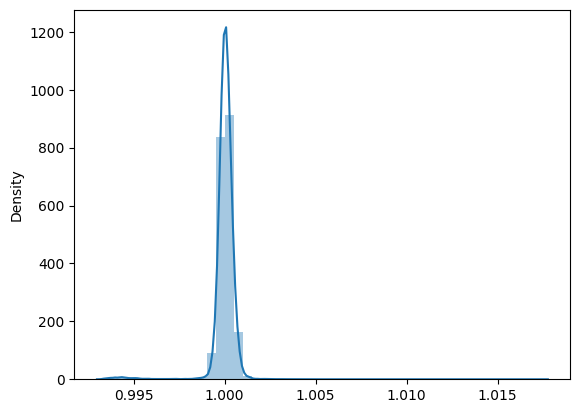

In [7]:
#Distribution of flux
sns.distplot(flux_arr)

Both flux seems to have a very tight 'tailedness'. We can quantify this by looking at the kurtosis of the distrbution. 

In [8]:
print(f"""
flux kurtosis : {scipy.stats.kurtosis(flux_arr)} 
"""
)


flux kurtosis : 52.75267825320591 



Both distributions have a kurtosis much larger than 3 which is what it would be for standard normal distrbution, indicating a very thin tailed distrbution. This means that goodness of fit tests that don't heavily weight distribution tails such as chi-squared would be best for evaluation rather than a Kolmogorov-Smirnov test.

<AxesSubplot: ylabel='Density'>

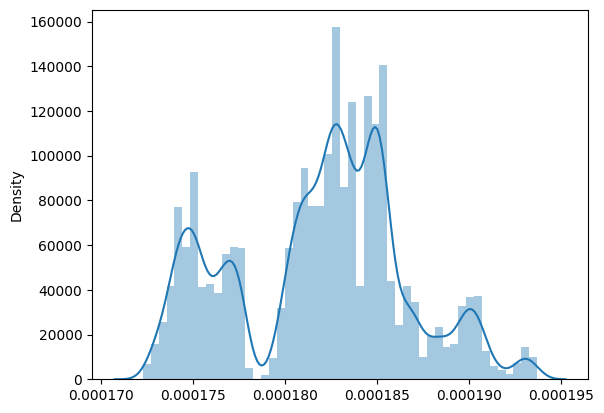

In [9]:
#Look at the distribution plot for the flux error for when we do MCMC simulation of full transit curve
sns.distplot(flux_error_arr)

This error term is clearly bimodal. When modelling error term when fitting a light curve, we will approximate this as the sum of a normal and inverse gamma distribution. 

<h2>Sigma clipping</h2>	


To some extent, the exoplanet orbital behaviour can be a stochastic process. Random noise will to some extent effect chi-squared calculations, 
to circumvent this we impliment sigma clipping, where we remove outliers more than 1 std above the sample mean. 

Text(0, 0.5, 'normalized stellar flux (watts/m^2)')

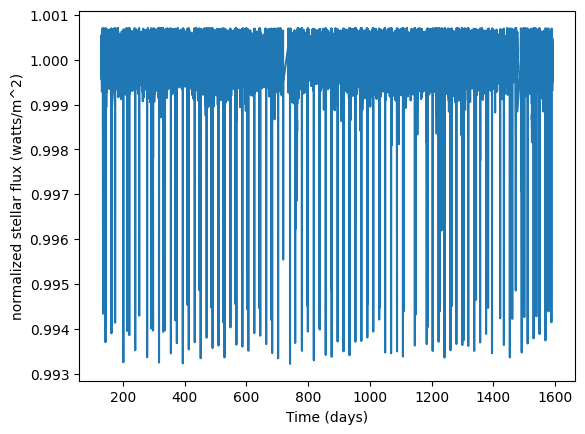

In [10]:
#Perform sigma clipping above the mean to clean the signal 
num_sigma = 1
num_sigma_above_mean = np.mean(sorted_flux) + num_sigma * (np.std(sorted_flux))

flux_value_mask = np.logical_and([x < num_sigma_above_mean for x in sorted_flux],  [x > -1000 for x in sorted_flux])
flux, flux_err, time = sorted_flux[flux_value_mask], sorted_flux_err[flux_value_mask], sorted_time[flux_value_mask]

#Remove single erroneous data point 
plt.plot(time, flux)
plt.xlabel('Time (days)')
plt.ylabel("normalized stellar flux (watts/m^2)")

Next we work to find the number of planets in the system, and the periods of all found exoplanets. 

Although our data is sampled (mostly) equally, we can make use of a Lomb–Scargle periodagram to identify transit periodicity. This works by
finding a 'fourier transform like' description of flux change as a function of period. Large delta function spikes indicate a good liklihood 
of a planet, and it's observed period. 

Text(0, 0.5, 'Power spectral density (PSD)')

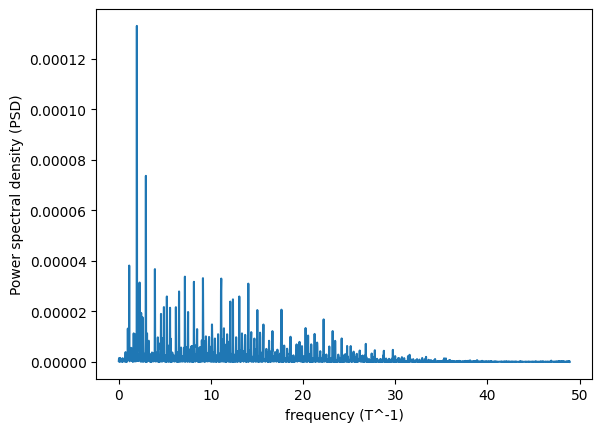

In [11]:
#Find an initial value and calcate the lombscarge of the flux values as a function of:
#The time signal 
#The flux at any given timestep
#The output frequency of the periodagram. 

T = time[-1] - time[0]
dt = time[1] - time[0]
freqs = np.linspace((1/T),(1/dt), 2000)
lomb = scipy.signal.lombscargle(time, flux, freqs, precenter=True)

plt.plot(freqs, lomb)
plt.xlabel('frequency (T^-1)')
plt.ylabel('Power spectral density (PSD)')

This plot seems noisy, this is likely a result of aliasing between planet orbits. We can find a good 
periodosity estimate by using another lombscargle to find the power periodagram as a function of the orbital period.

Text(0, 0.5, 'Power spectral density (PSD)')

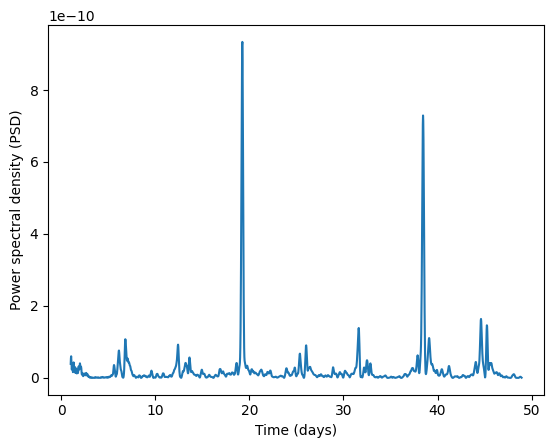

In [12]:
period = np.linspace(1, freqs[-1], 2000)
lomb2 = lombscargle(freqs, lomb, period, precenter = True)

plt.plot(period, lomb2)
plt.xlabel('Time (days)')
plt.ylabel('Power spectral density (PSD)')

In [13]:
periods_found_from_lomb = [19.221, 38.433512752318606]

Here we find two clear spikes corresponding to periods of 19.221 and 38.433 days. We can take these to be the periods for two found 
exoplanets. Next is to try to find estimates for transit depths for both of these found bodies, so that we can find the ratio of the stellar
radius to the planet radius given by 

$$ \frac{\Delta f}{f}  = \frac{R_{p}^{2}}{R_{*}^{2}}$$


where $R_p, R_*$ are the planetary and stellar radii respectively.

<h2>Curve fit for planet with period of around 38 days</h2>	



In [14]:
def chisquared_reduced(x, y, error, ymodel):

    chisquare = np.sum((y-ymodel)**2/error**2)
    reduced_chisquared = chisquare / (len(x) - 3 -1) # 3 degrees of freedom for the quartic fit hence -3 - 1 
    return reduced_chisquared

To find the value for $\Delta f / f$, we take a confirmed transit in our light curve and find the 'depth' of the drop in flux as $\Delta f$ and the sample mean as the flux. We can do this by fitting a low order polynomial to the transiting flux points, and reading out the value for the normalized flux minima. After some analysis, a quartic equasion seems to best model the smoothed parabola of a transit.

To make our transits much clearer for analysis, we fit our polynomial to a 'folded' light curve where flux is plotted against the remainder of the timestep divided by the period, denoted the relative phase. 

In [15]:
#Fold the light curve to find a folded time, phase, flux and flux error to analyse
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            periods_found_from_lomb[1]
    )

#Define the masks for the 3 different transits that we want to fit a quartic curve to 
area_mask_1 = (p_final > 1.585) & (p_final < 1.593) & (pflux_final < 0.99902)
area_mask_2 = (p_final > 1.573) & (p_final < 1.58) & (pflux_final < 0.9985)
area_mask_3 = (p_final > 1.614) & (p_final < 1.619) & (pflux_final < 0.998)

#Fit a curve to each of the three transits
popt1, cov1 = curve_fit(model_curve, p_final[area_mask_1], pflux_final[area_mask_1], p0 = [0.994,  1.587, 1.595], sigma = pflux_error_final[area_mask_1])
popt2, cov2 = curve_fit(model_curve, p_final[area_mask_2], pflux_final[area_mask_2], p0 = [0.994,  1.573, 1.581], sigma = pflux_error_final[area_mask_2])
popt3, cov3 = curve_fit(model_curve, p_final[area_mask_3], pflux_final[area_mask_3], p0 = [0.994,  1.609, 1.619], sigma = pflux_error_final[area_mask_3])

#Calculate the goodness of fit for each of the 3 fits 
reduced_chi_1 = reduced_chisquared(p_final, pflux_final[area_mask_1] , pflux_error_final[area_mask_1], model_curve(p_final[area_mask_1], *popt1))
reduced_chi_2 = reduced_chisquared(p_final, pflux_final[area_mask_2] , pflux_error_final[area_mask_2], model_curve(p_final[area_mask_2], *popt2))
reduced_chi_3 = reduced_chisquared(p_final, pflux_final[area_mask_3] , pflux_error_final[area_mask_3], model_curve(p_final[area_mask_3], *popt3))

print(f"""
    "reduced chi square score for fit number 1 : {reduced_chi_1},
    "reduced chi square score for fit number 2 : {reduced_chi_2},
    "reduced chi square score for fit number 3 : {reduced_chi_3},
    \n\n
    --------------------------------------------------
    average reduced chi square score is {np.mean([reduced_chi_1, reduced_chi_2, reduced_chi_3])} 
 """)

#Plot the 3 transits on the folded light curve along with the initial data
plt.figure(figsize = (12, 6))
plot_mask = (p_final < 1.7) & (p_final > 1.5) 
plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')

plt.plot(p_final[area_mask_1], model_curve(p_final[area_mask_1], *popt1), 'r-', marker="o", ms=3)
plt.plot(p_final[area_mask_2], model_curve(p_final[area_mask_2], *popt2), 'r-', marker="o", ms=3)
plt.plot(p_final[area_mask_3], model_curve(p_final[area_mask_3], *popt3), 'r-', marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)
plt.axhline(0.994, alpha=0.3, linewidth=5)
plt.xlabel('relative phase (rads day^-1)')
plt.ylabel("normalized stellar flux (watts/m^2)")
plt.show()

NameError: name 'model_curve' is not defined

From these found parameters for fitted curves, we can now find the error in the fit and the radius of the exoplanet.

In [ ]:
#First parameter is the depth reached, take the average over the 3 fits
depth1, depth2, depth3 = (1 - popt1[0]), 1 - popt2[0], 1 - popt3[0]

#The uncertinity in the depth reached from the fitted model is the first element of the diag of the covariance matrix of the curve fit
#We can find the 1 sigma errors in the fit by taking root of the found variances. 
uncertinty_depth_1, uncertinty_depth_2, uncertinty_depth_3 = np.sqrt(np.diag(cov1)[0]), np.sqrt(np.diag(cov2)[0]), np.sqrt(np.diag(cov3)[0])

#Find the average of the depth and the uncertinty in this. 
average_depth = np.mean([depth1, depth2, depth3])
average_depth_err = np.mean([uncertinty_depth_1, uncertinty_depth_2, uncertinty_depth_3])

stellar_radius = 1 #Given to be one stellar radius pm 2% hence we will multiply final err 1.02 
radius_ratio = np.sqrt(average_depth / np.mean(flux))
radius_ratio_err = np.sqrt(average_depth_err / np.mean(flux))

print(f"radius of the planet in stellar radii : {stellar_radius * radius_ratio} pm {(stellar_radius * radius_ratio_err)*1.02}")
print(f"radius of the planet in earth radii : {109.1 * stellar_radius * radius_ratio} pm {(109.1 * stellar_radius * radius_ratio_err)*1.02}")

radius of the planet in stellar radii : 0.07584182898830628 pm 0.011995559445529554
radius of the planet in earth radii : 8.274343542624216 pm 1.3087155355072742


This reduced chi squared is well over 3 sigma, meaning that we can keep the null hypothesis that the fit of the curves is drawn from the correct distribution and the fit is therefore 'good'. 

<h2>Curve fit for planet with period of around 19 days</h2>	


For the planet with the smaller period of 19 days, we will only do one fit and chi square calculation. This is because this planet will be our case 
study for habitability analysis, and thus we will later be fitting some much more complex models of transit. 

reduced chi for plot : 0.09654868414211289


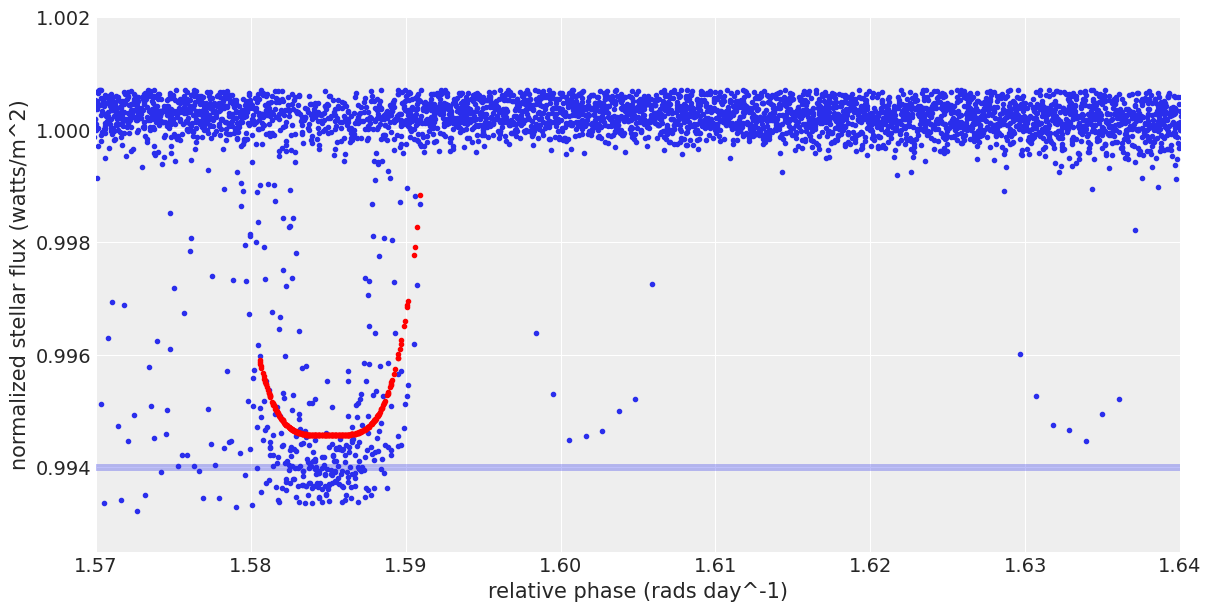

In [ ]:
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            period_guess
    )
#Define masks to fit the transit curve to, and a second for nice visualisation 
area_mask = (p_final > 1.5805) & (p_final < 1.593) & (pflux_final < 0.9995)
plot_mask = (p_final < 1.7) & (p_final > 1.5) 

#Fit the curve
popt4, cov4 = curve_fit(model_curve, p_final[area_mask], pflux_final[area_mask], p0 = [0.994, 1.58, 1.593])

reduced_chi_4 = reduced_chisquared(p_final, pflux_final[area_mask] , pflux_error_final[area_mask], model_curve(p_final[area_mask], *popt4))
print(f"reduced chi for plot : {reduced_chi_4}")

#Draw the figure 
plt.figure(figsize = (12, 6))
plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')
plt.plot(p_final[area_mask], model_curve(p_final[area_mask], *popt), 'r',ls="None", marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)

plt.axhline(0.994, alpha=0.3, linewidth=5)
plt.xlabel('relative phase (rads day^-1)')
plt.ylabel("normalized stellar flux (watts/m^2)")

plt.show()

Following the same method above, we can find the radius of the second planet in stellar radii.

In [ ]:
#First parameter is the depth reached,
depth4 = 1-popt4[0]

#The uncertinity in the depth reached from the fitted model is the first element of the diag of the covariance matrix of the curve fit
uncertinty_depth_4 = np.sqrt(np.diag(cov4)[0])

stellar_radius = 1 #Given to be one stellar radius pm 2% hence we will multiply final err 1.02 
radius_ratio = np.sqrt(depth4 / np.mean(flux))
radius_ratio_err = np.sqrt(uncertinty_depth_4 / np.mean(flux))

print(f"radius of the planet in stellar radii : {stellar_radius * radius_ratio} pm {(stellar_radius * radius_ratio_err)*1.02}")
print(f"radius of the planet in earth radii : {109.1 * stellar_radius * radius_ratio} pm {(109.1 * stellar_radius * radius_ratio_err)*1.02}")

radius of the planet in stellar radii : 0.07372293292053463 pm 0.010179591829656998
radius of the planet in earth radii : 8.043171981630326 pm 1.1105934686155785


In [ ]:
 109.1 * stellar_radius * radius_ratio

8.043171981630326

The implications of the found radius will be analysed in the relevent section. However, these simple curve fits do not yield 
many important parameters that we need for habitability analysis. More complex models are needed to account for orbital 
eccentricity, limb darkening in the host star or the impact parameter of the orbit. 

This extra modelling will be carried out in the discussion to further ascertain the suitability of the exoplanet with a period of 19 days to 
host life. 

### 3. Discussion

$\bullet$ present comparison of your results with data, including statistical analyis and clear figures. 

$\bullet$ limit yourself in the presentation of results, focus on fewer results that are described well, rather than presenting many figures without clear context

$\bullet$ Include a short (~ 200 word) description of a follow-up observations that would address an open question in your report.


<div class="alert alert-block alert-danger">
<b>Word limit: 2000 words</b>

Find priors for the bayesian fit 


    period : 19.223274881162116,
    transit guess : 145.7930129692552,
    depth_guess : 0.0021666865475383308
    


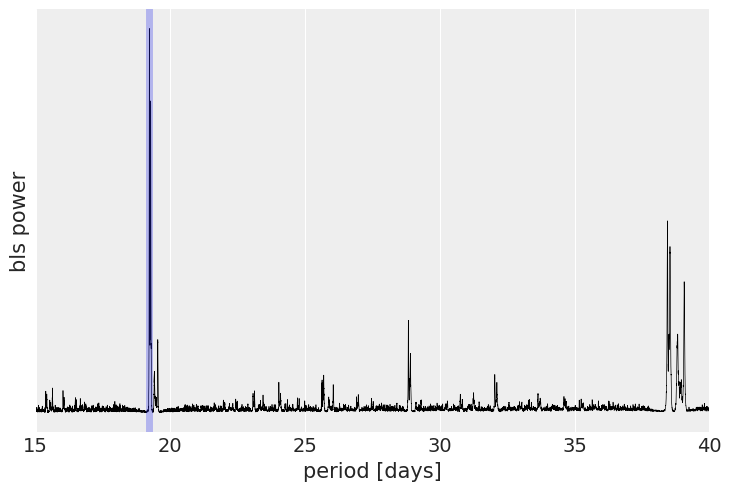

In [ ]:
#Find the period, transit and peak guesses using a box least squares estimator for greater accuracy
pg = xo.estimators.bls_estimator(time, flux, flux_err, min_period=15, max_period=40)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

print(f"""
    period : {period_guess},
    transit guess : {t0_guess},
    depth_guess : {depth_guess}
    """
)

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
_ = plt.xlim(pg["bls"].period.min(), pg["bls"].period.max())

In [ ]:
#Take only the data samples within 0.25 days of a transit 
transit_mask = (
    np.abs(
        (time - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
    )
    < 0.25
)
#Data cleaning, ensure that all are float64 arrays before modelling
x = np.ascontiguousarray(time[transit_mask])
y = np.ascontiguousarray(flux[transit_mask])
yerr = np.ascontiguousarray(flux_err[transit_mask])

x_fold = (
    x - t0_guess + 0.5 * period_guess
) % period_guess - 0.5 * period_guess

#Custom mask - used to remove the 'top' line' of the transit, this isn't really needed but allows final visualization plot to look nicer 
x_fold_cord_mask = (x_fold > -0.09) & (x_fold < 0.09)
final_mask = ~np.logical_and(x_fold_cord_mask, (y > 0.999))

x = x[final_mask]
x_fold = x_fold[final_mask]
y = y[final_mask]
yerr = yerr[final_mask]

#Show the data that is being fitted to
plt.figure(figsize=(8, 4))
plt.scatter(x, y, c=x, s=3)
plt.axvline(800, alpha=0.3, linewidth=5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")


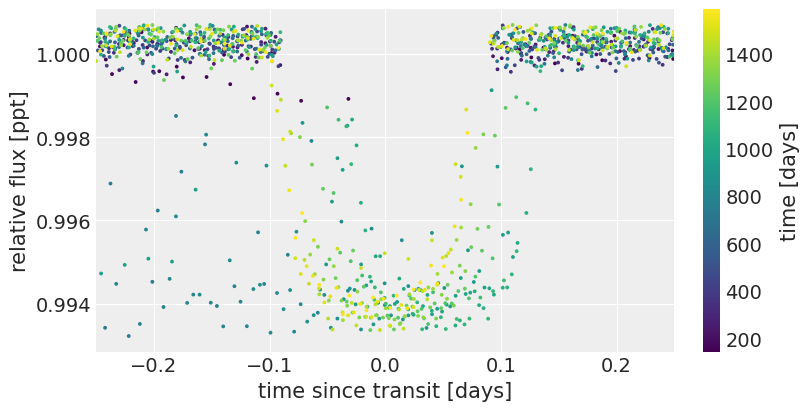

In [ ]:
#Plot a lightcurve fold to visualize the 'average' transit for this given period
plt.figure(figsize=(8, 4))
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

By trying to dialias I have lost the light curve transits for the first 800 day datapoints. 

In the folded curve, we can see aliasing causing noise up until around 1000 days in. 

Deal with this by clipping data at 1000 days

In [ ]:
#Mask the time array to remove all flux values for before 1000 days into recording
X_mask_alias = [x > 1000]
x = x[X_mask_alias]
x_fold = x_fold[X_mask_alias]
y = y[X_mask_alias]
yerr = yerr[X_mask_alias]

#Plot the resulting folded light curve 
plt.figure(figsize=(8, 4))
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

Much nicer!


1. MCMC Model 

In [ ]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

depth_guess = 0.0057
with pm.Model() as model_reduced:
    
    # Stellar parameters
    mean = pm.Normal("flux_mean", mu=1.0006, sigma=0.001)
    u = xo.QuadLimbDark("limbdark")
    star_params = [mean, u]

    # Planet parameters
    log_ror = pm.Normal(
        "log_radius_ratio", mu=0.5 * np.log(depth_guess * 1e-3), sigma=0.1
    )
    ror = pm.Deterministic("radius_ratio", tt.exp(log_ror))

    #Error parameters
    err_inverse_gamma = pm.InverseGamma("err_gamma", alpha=3.0, beta=1 * np.median(yerr))
    err_gauss = pm.Normal("err_gauss", mu=0, sigma=2 * np.std(yerr))
    err = pm.Deterministic('err_total', err_inverse_gamma + err_gauss)

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=0.05)
    period = pm.Deterministic("period", tt.exp(log_period))
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_duration", mu=np.log(0.17), sigma=0.05)
    dur = pm.Deterministic("duration", tt.exp(log_dur))
    b = xo.distributions.ImpactParameter("impact_parameter", ror=ror,)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=period, 
        duration=dur, 
        t0=t0, 
        b=b,
        )

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("stellar_density", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)
    lc_model = mean + 1e3 * tt.sum(
        star.get_light_curve(orbit=orbit, r=ror, t=x), axis=-1
    )


    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model_reduced.check_test_point())

    # Optimize the model
    map_soln = model_reduced.test_point
    map_soln = pmx.optimize(map_soln, [ror, b, dur])
    map_soln = pmx.optimize(map_soln, err)
    map_soln = pmx.optimize(map_soln, star_params)
    map_soln = pmx.optimize(map_soln)

flux_mean                     5.99
limbdark_quadlimbdark__      -2.77
log_radius_ratio              1.38
err_gamma_log__              -0.53
err_gauss                    10.54
log_period                    2.08
t0                           -0.92
log_duration                  2.08
impact_parameter_impact__    -1.39
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_duration, impact_parameter, log_radius_ratio]


message: Optimization terminated successfully.
logp: 16.454590124674844 -> 16.454595797570967


optimizing logp for variables: [err_gamma, err_gauss]


message: Optimization terminated successfully.
logp: 16.454595797570967 -> 16.59154958020752


optimizing logp for variables: [limbdark, flux_mean]


message: Optimization terminated successfully.
logp: 16.59154958020752 -> 16.59154958020752


optimizing logp for variables: [impact_parameter, log_duration, t0, log_period, err_gauss, err_gamma, log_radius_ratio, limbdark, flux_mean]


message: Optimization terminated successfully.
logp: 16.59154958020752 -> 16.59154958020752


In [ ]:

with model_reduced:
    lc_pred = pmx.eval_in_model(lc_model, map_soln)

In [ ]:
with model_reduced:
    trace_small = pm.sample(
        tune=4000,
        draws=4000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )
import pickle 
with open("trace.pkl", "wb") as f: 
    pickle.dump(trace_small, f)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [impact_parameter, log_duration, t0, log_period, err_gauss, err_gamma, log_radius_ratio, limbdark, flux_mean]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


In [ ]:
with model_reduced:
    sample_summary = az.summary(trace_small)
#stellar density has sample cases where due to overflow it is NAN, this will be cleaned up manually later.
sample_summary

arviz - WARNING - Array contains NaN-value.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
flux_mean,1.001,0.001,0.999,1.003,0.000,0.000,9594.0,6259.0,1.0
log_radius_ratio,-6.038,0.099,-6.218,-5.848,0.001,0.001,11232.0,6146.0,1.0
err_gauss,0.000,0.000,-0.000,0.000,0.000,0.000,11220.0,6335.0,1.0
log_period,2.956,0.050,2.862,3.048,0.001,0.000,9807.0,5956.0,1.0
t0,145.786,1.021,143.841,147.697,0.010,0.007,10207.0,6250.0,1.0
log_duration,-1.772,0.050,-1.863,-1.675,0.000,0.000,10818.0,6464.0,1.0
limbdark[0],0.662,0.475,0.000,1.505,0.005,0.004,9336.0,5553.0,1.0
limbdark[1],0.002,0.413,-0.749,0.770,0.004,0.004,9384.0,5281.0,1.0
radius_ratio,0.002,0.000,0.002,0.003,0.000,0.000,11232.0,6146.0,1.0
err_gamma,0.000,0.000,0.000,0.000,0.000,0.000,9460.0,4997.0,1.0


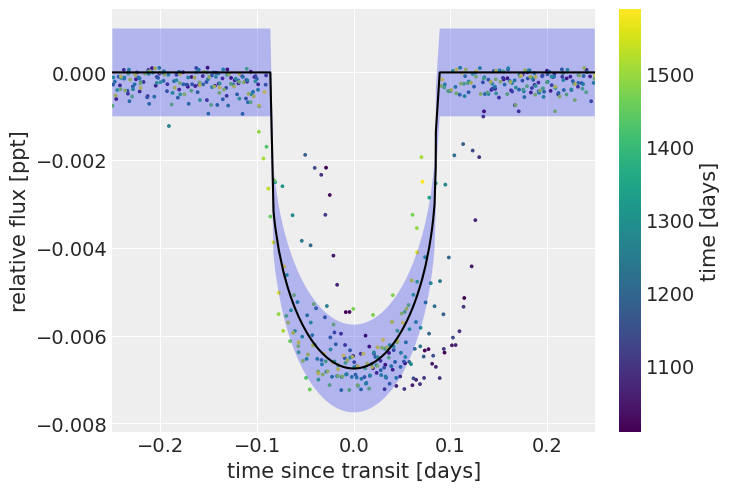

In [ ]:
inds = np.argsort(x_fold)

plt.scatter(x_fold, y  - map_soln["flux_mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["flux_mean"], "k")
plt.fill_between(x_fold[inds],
            y1 = lc_pred[inds] - map_soln["flux_mean"] - sample_summary['sd']['flux_mean'], 
            y2 = lc_pred[inds] - map_soln["flux_mean"] + sample_summary['sd']['flux_mean'],
            alpha = 0.3
    )
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

Ensuring good fit 

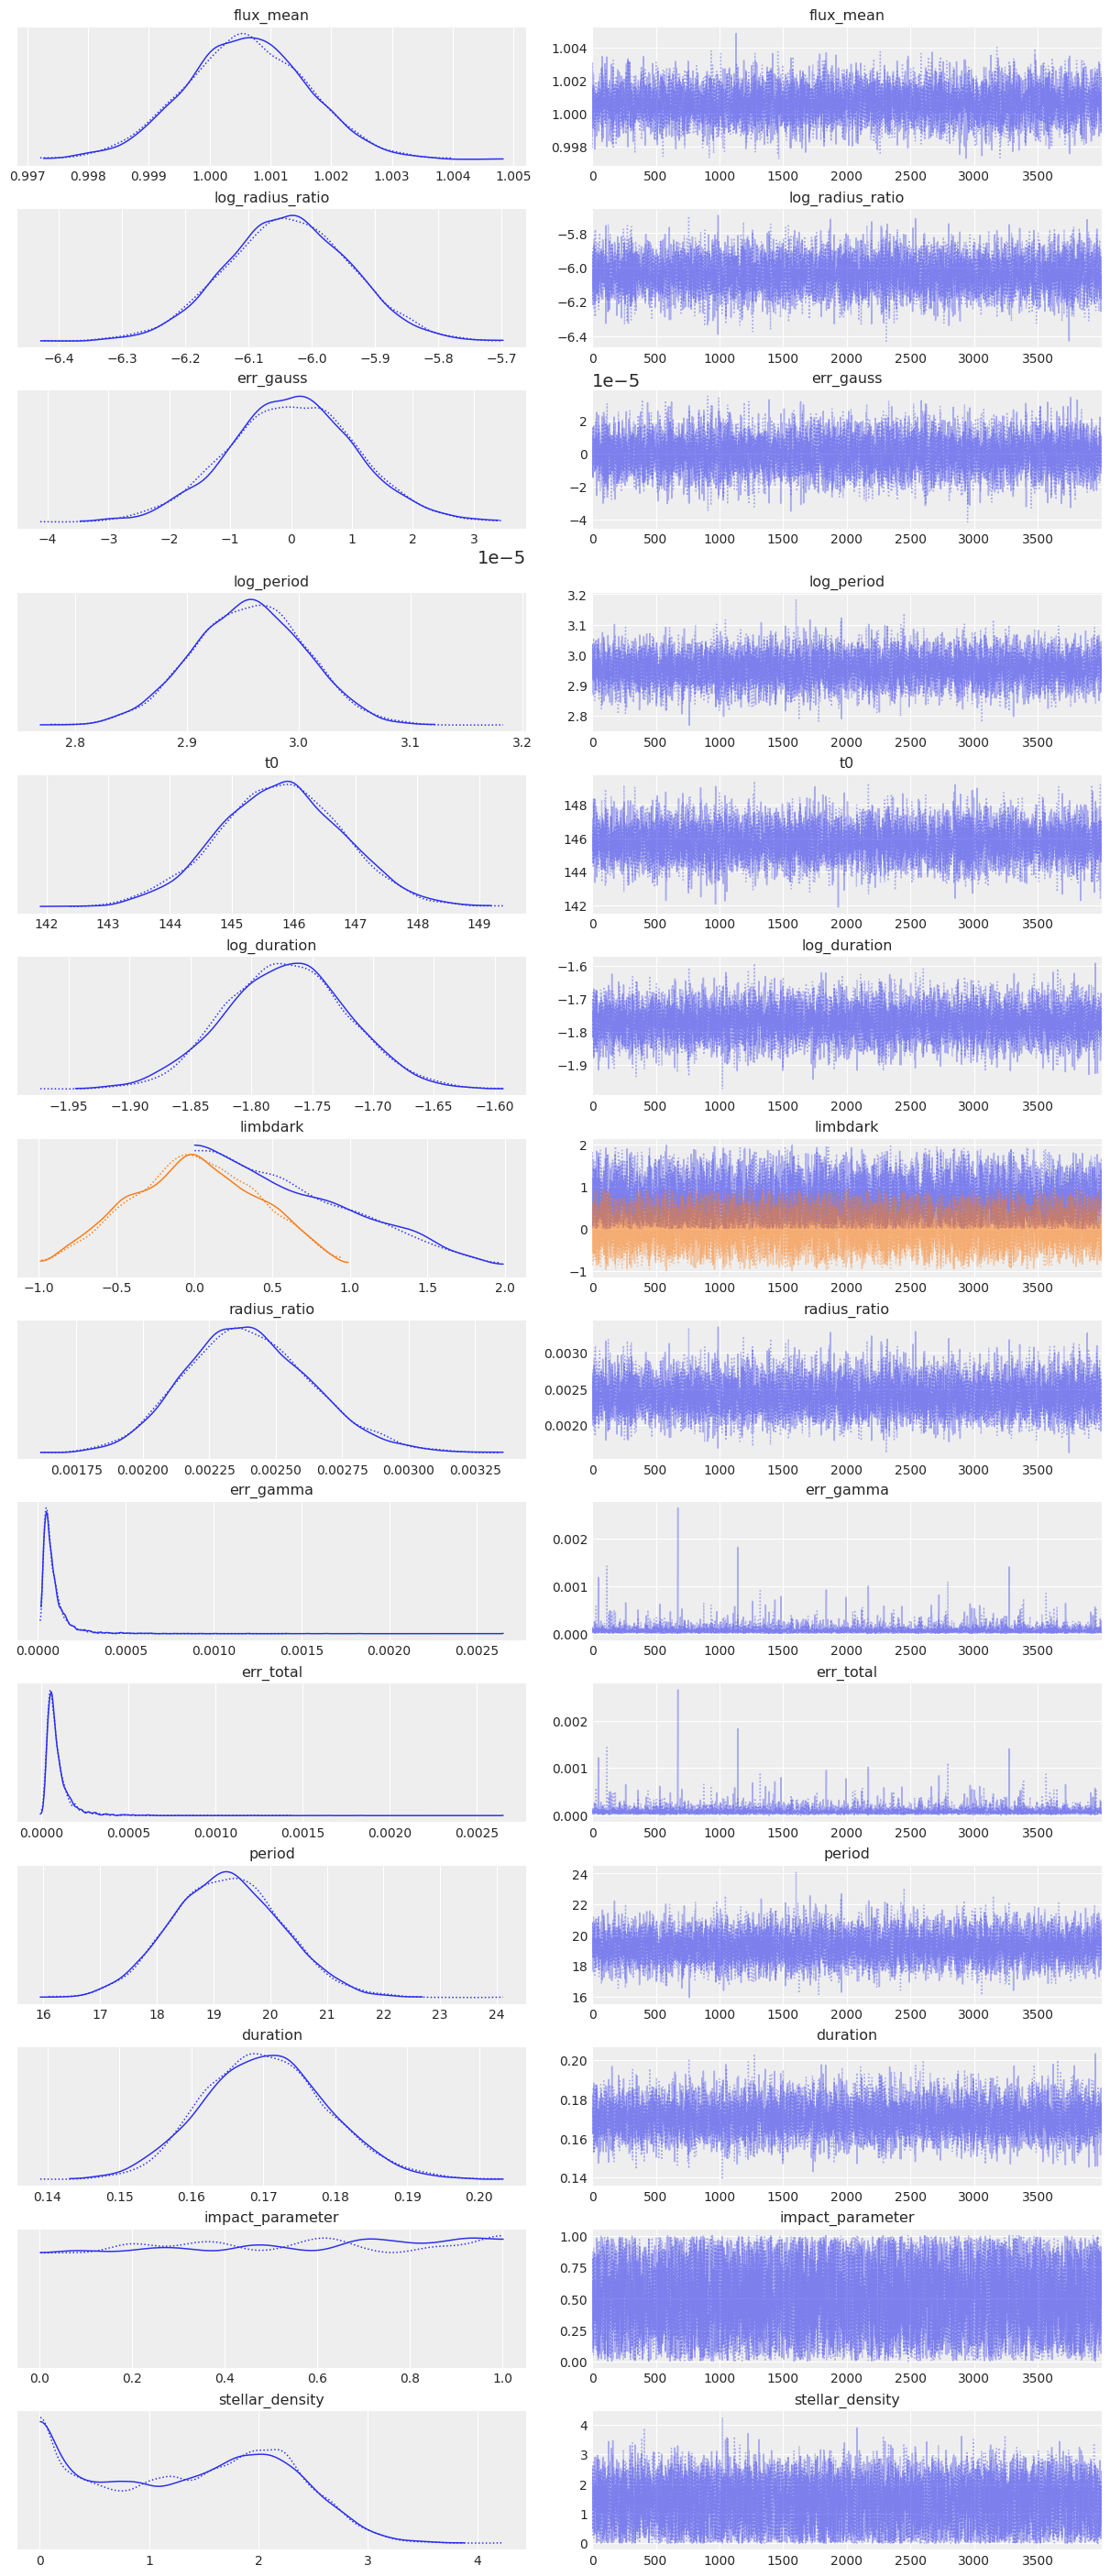

In [ ]:
import arviz as az
az.style.use("arviz-darkgrid")

with model_reduced:
    az.plot_trace(trace_small)

FIND SEMI MAJOR AXIS 

Keplers law 


$$ T^2 = \frac{4 \pi ^2}{GM} a^3$$

$$\frac{T^2  GM}{4 \pi ^2} = a^3$$

In [ ]:
orbit_period_mean = sample_summary['mean']['period'] * 24 * 3600
orbit_period_std = sample_summary['sd']['period']* 24 * 3600

stellar_mass = 1.98847e30
G = 6.67430e-11
au =  1.495978707e11

semi_major_axis_mean = np.cbrt((orbit_period_mean**2 * G* stellar_mass) / (4 * np.pi**2)) / au 
semi_major_axis_std = np.cbrt((orbit_period_std**2 * G* stellar_mass) / (4 * np.pi**2)) * 1.02 / au #Multiply by 1.02 to account for 2% uncertinity in Stellar mass error.

In [ ]:
print(f"semi major axis (1.sd) : {semi_major_axis_mean} +- {semi_major_axis_std} au")

df = pd.read_csv(os.getcwd() +  "/tess_data.csv")

fig, ax = plt.subplots()
sns.distplot(df[np.isfinite(df['pl_orbsmax'].values)]['pl_orbsmax'], ax = ax, label= "tess data")
plt.scatter(semi_major_axis_mean, 1, label = "found planet")
plt.errorbar(semi_major_axis_mean, 1, xerr=semi_major_axis_std*3, fmt='o', label = "planet S.M error (3 sigma)")
plt.xlabel("semi major axis (AU)")
plt.title("distribution plot of Semi Major Axis of TESS candidates")
plt.legend()
plt.show()

NameError: name 'semi_major_axis_mean' is not defined

In [ ]:
sf

FIND ECCENTRICITY AND ANGLE OF INCLINATION

In [ ]:
#On trace plot chains visably diverge, check the z score to see if chains reasonably drawn from same distribution and can be averaged by finding 
#Z score between two chains 
chain_rho_circ_1 = trace_small.posterior["stellar_density"].to_numpy()[0]
chain_rho_circ_2 = trace_small.posterior["stellar_density"].to_numpy()[1]
mask = np.logical_and(np.isfinite(chain_rho_circ_1), np.isfinite(chain_rho_circ_2))

np.abs((np.mean(chain_rho_circ_1[mask]) - np.mean(chain_rho_circ_2[mask])) / np.sqrt(np.std(chain_rho_circ_1[mask]**2)-np.std(chain_rho_circ_2[mask])**2))

0.017498600158840378

Value much smaller than 2 so they are drawn from the same sufficiently 'stable' distribution and chains are in agreement

Equivelent to a p value of approx 0.996 or nearly 3 sigma 

In [ ]:
rho_circ = np.repeat(np.asarray(trace_small.posterior["stellar_density"]).flatten(), 100)
rho_mask = np.isfinite(rho_circ)
rho_circ = rho_circ[rho_mask]

#Taken from assumed stellar mass and radius being 1 stellar mass and radius pm 2%
#Density = mass / volume of sphere, uses r^3 and mass once, linear operations yield
# Additive errors so it is 0.02 * 4 for error prop.
tic_rho_star = (1, 0.08)

In [ ]:
np.asarray(trace_small.posterior["impact_parameter"]).flatten()

(array([0.69049408, 0.36702539, 0.71724704, ..., 0.22029048, 0.62574883,
        0.52220746]),
 100)

In [ ]:
# Sample eccentricity and omega from their (uninformative) priors
ecc = np.random.uniform(0, 1, len(rho_circ))
omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

# Compute the "g" parameter from Dawson & Johnson and what true
# density that implies
g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc**2)
rho = rho_circ / g**3

# Re-weight these samples to get weighted posterior samples
log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
weights = np.exp(log_weights - np.max(log_weights))

# Estimate the expected posterior quantiles
q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights)
print(
    "eccentricity = {0:.2f} +{1[1]:.2f} -{1[0]:.2f}".format(q[1], np.diff(q))
)

eccentricity = 0.31 +0.30 -0.19


Impact parameter seems highly degerate with, omega, along with large value makes for suprious inference of the eccentricity. 

IMPACT PARAMETER

$$b = \frac{a cos(i)}{R_{*}}$$

In [ ]:
print(np.arccos(np.mean(trace_small.posterior['impact_parameter'].to_numpy()) * (0.00465047) / semi_major_axis_mean),
    "+-",
    np.arccos(np.std(trace_small.posterior['impact_parameter'].to_numpy()) * (0.00465047) / semi_major_axis_std),
    "radians"
)

1.553949921887626 +- 1.5016653240589193 radians


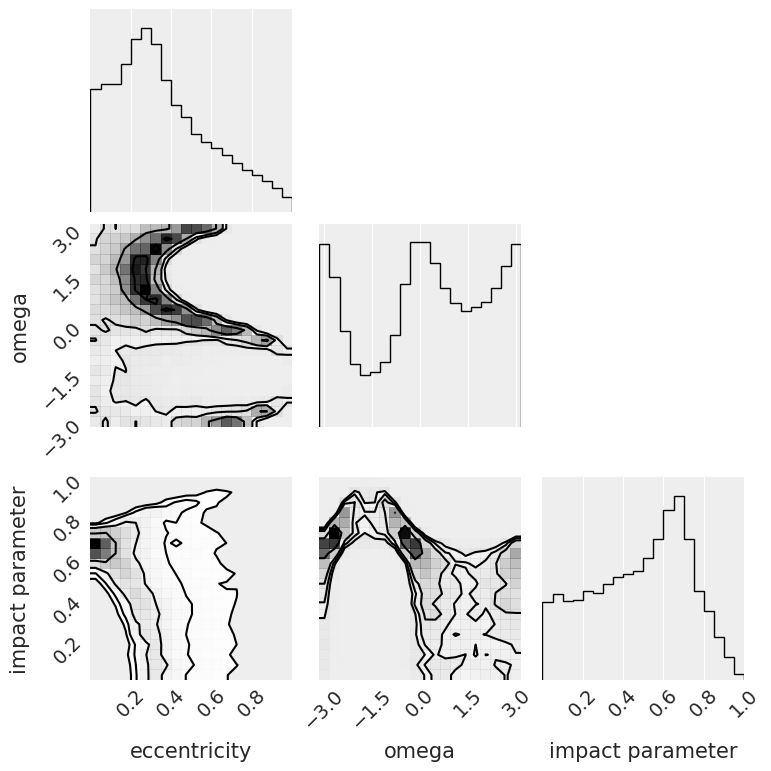

In [ ]:
#Make corner plot
_ = corner.corner(
    np.vstack((ecc, omega, impact)).T,
    weights=weights,
    plot_datapoints=False,
    labels=["eccentricity", "omega", 'impact parameter'],
)

Goldilocks zone calculation 

Luminosity 

### 4. Summary

$\bullet$ summarize your results. This can be done in text or bullet points.

<div class="alert alert-block alert-danger">
<b>Word limit: 300 words</b>

### References:

Give all references here. Use Astronomy style references, e.g.
- Miller & Jones, 2018, ApJ, 00, 000
- Smith et al. 2019, MNRAS, 00, 000
- Willow 1972, AJ, 00, 000

And cite these in the text as "Miller & Jones (2018) showed that all exoplanets are made of cheese, however, Smith et al. (2019) showed Trappist1b is made of chocolate, as previously suggested in the literature (Willow 1972)." 


### Acknowledgments

Acknowlegde the use of any software or datasets here.